# 2. Representative selection, Li et al.
___
Dr. Raffael lab <br>
2024

In [2]:
import os
import sys
import subprocess
import numpy as np
from pathlib import Path

import pandas as pd
from tqdm import tqdm

from Bio import SeqIO
import matplotlib.pyplot as pl

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Characterize input fastas

In [2]:
allseqspath = Path('Lietal_FetchedSeqs/parsed_fastas_cleaned_temped/MeetingOrgCountCrit')
file_sizes_mb = [f.stat().st_size/1000000 for f in allseqspath.iterdir() if f.is_file()]

In [3]:
file_sizes_mb

[0.334216]

In [5]:
#Delete Cell 
for f in allseqspath.iterdir(): 
    if f.is_file():
        print(f)

Lietal_FetchedSeqs/parsed_fastas_cleaned_temped/MeetingOrgCountCrit/steroid_DELTA-isomerase.fa


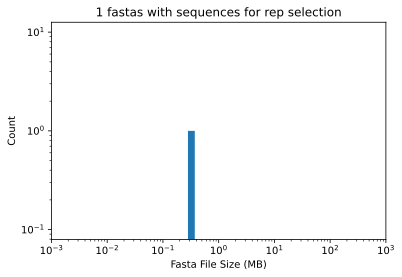

In [6]:
pl.hist(file_sizes_mb, bins = np.logspace(np.log10(0.001),np.log10(1000), 50))
pl.yscale('log');
pl.xscale('log')
pl.ylabel('Count');
pl.xlim(10**-3, 10**3)
pl.xlabel('Fasta File Size (MB)');
pl.title('{} fastas with sequences for rep selection'.format(len(file_sizes_mb)));

### Helper functions for rep selection

In [17]:
def readBlastResults(blastHandle):
    """Reads and parses into a dataframe the raw blast output 
    file generated to select a representative sequence. The blast
    format is specified by the following outfmt parameter passed to blastp:
    
    -outfmt "6 qaccver saccver pident length mismatch gapopen\
    qstart qend sstart send evalue bitscore gaps qlen slen"
    
    Arguments:
        (str | pathlib.Path) blastHandle: path of the temporary blast 
            results file
    
    Returns:
        (str) accession of the selected representative
    
    """
    # Parsing raw records
    col_labels = ['query_id', 'subject', 'percent_identMatches', 'aln_len', 
                  'num_mismatches', 'num_gapOpenings', 'start_aln_inQuery', 
                  'end_aln_inQuery', 'start_aln_inSubject', 'end_aln_inSubject', 
                  'e_val', 'bit_score', 'num_gaps', 'query_len', 'subject_len']
    pairwise_df = pd.read_csv(blastHandle, delimiter = '\t', names = col_labels)
    pairwise_df_selfRemoved = pairwise_df.loc[pairwise_df.percent_identMatches != 100] #Remove self queries
    pairwise_df_selfRemoved['e_val_transformed'] = pairwise_df_selfRemoved.e_val.apply(lambda ev: -np.log10(ev))

    bs_means = pairwise_df_selfRemoved.groupby('query_id').agg('sum')['bit_score'].reset_index()
    reset_bs_means = bs_means.sort_values('bit_score', ascending=False).reset_index(drop = True).reset_index(drop = False).rename(mapper = str, columns = {'index': 'ind'})
    lenbs = len(reset_bs_means)

    summedres = reset_bs_means.copy().set_index('query_id').rename(mapper = str, columns = {'bit_score': 'sum_bit_score'})
    rawres = pairwise_df_selfRemoved.copy().set_index('query_id')
    
    # Rep selection based on the sum of bit scores
    joined = rawres.join(summedres).sort_values('sum_bit_score', ascending = False).reset_index()
    best_results = joined.set_index('query_id').sort_values('sum_bit_score', ascending = False)
    representative = best_results.iloc[0]
    rep_accession = best_results.iloc[0].name.split('|')[0]
    return rep_accession


def findBlastRep(blastTmpPath, short_list_handle, enzyme):
    """Performs all by all blast for a short list of representative
    candidate sequences to generate scores used to pick the finale
    representative
    
    Arguments:
        (pathlib.Path) blastTmpPath: root folder containing temporary blast
            result files
        (str) short_list_handle: path of short list of candidate representatives
            with which to perform all by all blast to select rep
        (str) enzyme: enzyme name corresponding to blast candidate short list
    
    Returns:
        (str) the path of the all by all blast results in the temporary blast folder
    
    """
    qry = short_list_handle
    blastPath = blastTmpPath.joinpath(Path('blast_xbyx/'))
    blastPath.mkdir(parents=True, exist_ok=True)

    b_db = '/Users/varundeepakgudhe/Downloads/osx-64_blast-2.7.1-h96bfa4b_5/bin/makeblastdb'
    db_name = blastPath.joinpath(Path('{}_blastDB'.format(enzyme)))
    cmd_makeDB = '{b_db} -in "{q}" -dbtype prot -out "{db}"'.format(b_db = b_db, q = qry, db = db_name)
    makeDB = subprocess.Popen(cmd_makeDB, shell=True)
    db_results = makeDB.communicate()[0]

    db_name = blastPath.joinpath(Path("{}_blastDB".format(enzyme)))

    blastp_loc = '/Users/varundeepakgudhe/Downloads/osx-64_blast-2.7.1-h96bfa4b_5/bin/blastp'
    outFile = blastPath.joinpath(Path("BLASTe10"))
    numThreads = '20'
    outfmt = '6 qaccver saccver pident length mismatch gapopen qstart qend sstart send evalue bitscore gaps qlen slen'
    
    cmd_query = '{b_loc} -db "{db}" -query "{q}" -outfmt "{of}" -out "{o}" -max_hsps 1 \
    -evalue 10e10 -max_target_seqs 100000 -num_threads {nt}'.format(b_loc = blastp_loc, 
                                                                    db = db_name, 
                                                                    q = qry, 
                                                                    of = outfmt, 
                                                                    o = outFile, 
                                                                    nt = numThreads
                                                                   )
    
    makeDB = subprocess.Popen(cmd_query, shell=True)
    blastResults = makeDB.communicate()[0]
    return outFile


def performPairwiseBlast(blastTmpPath, fasta_handle, enzyme, max_seqs = 250):
    """High level function to perform pairwise blast on a set of candidate representative
    sequences. The final representative candidate is used as teh reference against
    which to perform pairwise blast against each other fetched sequence.
    
    Arguments:
        (str) blastTmpPath: path to house temporary blast results
        (str) fasta_handle: file handle of fasta containing all sequences
            gathered for a given enzyme
        (str) enzyme: enzyme name corresponding to blast candidate 
            representative short list
        (int) max_seqs: maximal number of candidates to consider as 
            potential representatives

    Returns:
        (str) blast file handle correponding to all-by-all blast of a short
            list of potential candidate sequences
    
    """
    print("HEY")
    lengths = [len(record.seq) for record in SeqIO.parse(fasta_handle, 'fasta')]
    medianLen = np.median(lengths)
    lowLenBound, highLenBound = (0.95*medianLen, 1.05*medianLen)
    seqsMeetingLenCrit = [record 
                          for record in SeqIO.parse(fasta_handle, 'fasta') 
                          if len(record.seq) > lowLenBound 
                          and len(record.seq) < highLenBound
                         ]

    cleanfapath = Path(blastTmpPath.joinpath('blast_xbyx/')).joinpath('cleanreps.fa')
    
    if len(seqsMeetingLenCrit) > max_seqs:
        np.random.seed(seed = 1)
        seqsForBlast = np.random.choice(seqsMeetingLenCrit, max_seqs, replace = False)
    else:
        seqsForBlast = seqsMeetingLenCrit

    SeqIO.write(seqsForBlast, cleanfapath, 'fasta')
    return findBlastRep(blastTmpPath, cleanfapath, enzyme)

### Execute rep selection

In [20]:
fastaRoot= Path('Lietal_FetchedSeqs/parsed_fastas_cleaned_temped/MeetingOrgCountCrit')
repFile = Path('Lietal_BlastReps/200128_Lietal_BlastReps.txt')
blastTmpPath = Path('BlastTmp')

for fh in tqdm(fastaRoot.iterdir(), total = 1): #change this total to number of files, I am keeping 2 as we have ipynb_checkpoints too.
    if fh.is_file():
        print(fh)
        with open(repFile, 'a+') as rf:
            try:
                enzyme_name = fh.stem
                blastPath = blastTmpPath.joinpath(Path('blast_xbyx/'))
                blastPath.mkdir(parents=True, exist_ok = True)
                rep = readBlastResults(performPairwiseBlast(blastTmpPath, fh, enzyme_name))
                rf.write('{}\t{}\n'.format(fh.stem, rep))
            except:
                rf.write('{}\t{}\n'.format(fh.stem, 'FAILED'))
                pass
            try: #clean up blast tmp files
                os.system('rm -r {}'.format(str(blastPath)))
            except:
                pass

###########################

### Gather the representatives into a record and obtain counts of successfully represented alignments

In [21]:
repFile = Path('Lietal_BlastReps/200128_Lietal_BlastReps.txt')

representatives = pd.read_csv(repFile, delimiter = '\t', names = ['enzName' ,'rep'])
representatives['Rep_Selected'] = representatives.rep!='FAILED'
representatives.groupby('Rep_Selected').count()

,enzName,rep
Rep_Selected,,
True,1,1


In [22]:
representatives.loc[~representatives.Rep_Selected]

,enzName,rep,Rep_Selected


### Re-parse each fasta corresponding to each enzyme and obtain the sequence corresponding to the rep

In [24]:
fastaRoot= Path('Lietal_FetchedSeqs/parsed_fastas_cleaned_temped/MeetingOrgCountCrit')

indexed_reps = representatives.set_index('enzName')
rep_recs_extended = []

for fh in tqdm(fastaRoot.iterdir(), total = 1):
    print(fh)
    enz_name = fh.stem
    rep_record = indexed_reps.loc[enz_name]
    rep_acc = rep_record.rep
    if rep_record.Rep_Selected:
        rep_matches = [r for r in SeqIO.parse(fh, 'fasta') if rep_acc in r.name]
        if len(rep_matches) == 0:
            raise ValueError('No matching representative found')
        elif len(rep_matches) == 1:
            rep_recs_extended.append({'name': enz_name, 
                                      'fullpath': str(fh), 
                                      'rep_desc': rep_matches[0].description, 
                                      'rep_seq': ''.join(rep_matches[0].seq)
                                     }
                                    )
        else:
            raise ValueError('More than one matching representative found')
    else:
        pass
    
rep_recs_extended_df = pd.DataFrame(rep_recs_extended)
rep_recs_extended_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.89it/s]

Lietal_FetchedSeqs/parsed_fastas_cleaned_temped/MeetingOrgCountCrit/steroid_DELTA-isomerase.fa


,name,fullpath,rep_desc,rep_seq
0,steroid_DELTA-isomerase,Lietal_FetchedSeqs/parsed_fastas_cleaned_tempe...,OBI39333.1|1038276474|steroid DELTA-isomerase|...,MPNAAKTEAIKSTVNRYIELVAKGSADDLVELYADDATVEDPVGGE...


In [25]:
rep_recs_extended_df.to_csv('Lietal_BlastReps/200128_Lietal_BlastReps_Summary.csv', index = False)